https://www.kaggle.com/datasets/ganjerlawrence/mobile-phone-price-prediction-cleaned-dataset/data

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
df = pd.read_csv("Mobile-Price-Prediction-cleaned_data.csv")
df

,Ratings,RAM,ROM,Mobile_Size,Primary_Cam,Selfi_Cam,Battery_Power,Price
0,4.3,4.0,128.0,6.00,48,13.0,4000,24999
1,3.4,6.0,64.0,4.50,48,12.0,4000,15999
2,4.3,4.0,4.0,4.50,64,16.0,4000,15000
3,4.4,6.0,64.0,6.40,48,15.0,3800,18999
4,4.5,6.0,128.0,6.18,35,15.0,3800,18999
...,...,...,...,...,...,...,...,...
802,3.8,6.0,32.0,4.54,48,12.0,2800,1299
803,4.1,8.0,64.0,4.54,64,8.0,2500,1390
804,4.4,3.0,32.0,6.20,48,1.0,3800,9790
805,3.7,10.0,32.0,4.50,64,8.0,3500,799


In [7]:
df.isnull().sum()

Ratings          0
RAM              0
ROM              0
Mobile_Size      0
Primary_Cam      0
Selfi_Cam        0
Battery_Power    0
Price            0
dtype: int64

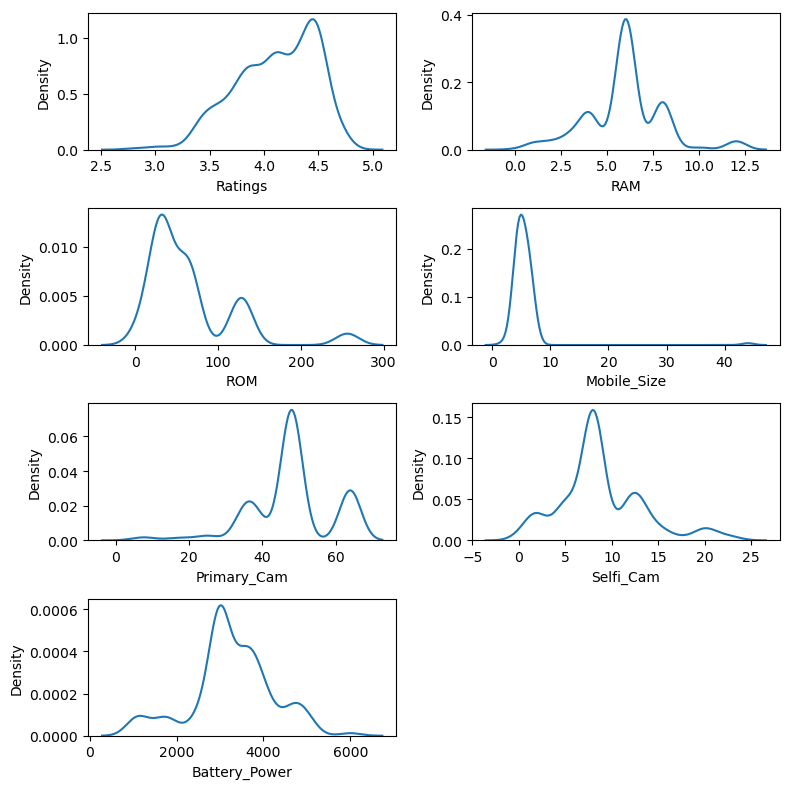

In [9]:
fig, axis = plt.subplots(nrows = 4, ncols = 2, figsize = (8, 8))
cols = df.drop("Price", axis = 1).columns
axis = axis.flatten()
for i, col in enumerate(cols):
    sns.kdeplot(x = df[col], ax = axis[i])

for ax in axis[len(cols):]:
    fig.delaxes(ax)
plt.tight_layout()
plt.show()

In [35]:
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from xgboost import XGBRegressor
from catboost import CatBoostRegressor
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, BaggingRegressor, ExtraTreesRegressor, StackingRegressor, VotingRegressor, AdaBoostRegressor
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import mean_squared_error, r2_score

In [37]:
X = df.drop("Price", axis = 1)
y = df["Price"]
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 22, test_size = 0.1)

In [13]:
import optuna

In [49]:
def objective(trial):
    param_grid = {
        'max_depth' : trial.suggest_int('max_depth', 1, 20),
        'learning_rate' : trial.suggest_float("learning_rate", 1e-3, 1.0, log = True),
        "min_child_weight" : trial.suggest_int("min_child_weight", 1, 10),
        "subsample" : trial.suggest_float("subsample", 0.5, 1.0),
        "colsample_bytree" : trial.suggest_float("colsample_bytree", 0.5, 1.0),
        "gamma" : trial.suggest_float("gamma", 1e-8, 1.0, log = True),
        "reg_alpha" : trial.suggest_float("reg_alpha", 1e-8, 1.0, log = True),
        "reg_lambda" : trial.suggest_float("reg_lambda", 1e-8, 1.0, log = True)
    }

    model = XGBRegressor(**param_grid)
    model.fit(X_train, y_train)

    preds = model.predict(X_test)
    rmse = np.sqrt(mean_squared_error(y_test, preds))
    return rmse

In [51]:
study = optuna.create_study(direction = "minimize")
study.optimize(objective, n_trials = 100)

[I 2024-07-17 21:13:16,171] A new study created in memory with name: no-name-a9e8905f-ed95-4ad2-8eec-06c706c87b7c
[I 2024-07-17 21:13:16,310] Trial 0 finished with value: 12071.000835457306 and parameters: {'max_depth': 19, 'learning_rate': 0.07023429126277694, 'min_child_weight': 3, 'subsample': 0.6962593305366499, 'colsample_bytree': 0.8553316951947321, 'gamma': 0.0007782901776077475, 'reg_alpha': 1.6650574592769586e-05, 'reg_lambda': 2.1315920251893066e-06}. Best is trial 0 with value: 12071.000835457306.
[I 2024-07-17 21:13:16,346] Trial 1 finished with value: 14330.203098619617 and parameters: {'max_depth': 2, 'learning_rate': 0.041323822013965165, 'min_child_weight': 10, 'subsample': 0.5376634708330794, 'colsample_bytree': 0.8453502254505021, 'gamma': 0.00012771475177952122, 'reg_alpha': 7.385701131335555e-06, 'reg_lambda': 0.23389364559456574}. Best is trial 0 with value: 12071.000835457306.
[I 2024-07-17 21:13:16,407] Trial 2 finished with value: 22946.158834962196 and paramete

In [53]:
best_params = study.best_params
best_params

{'max_depth': 12,
 'learning_rate': 0.03132057105894967,
 'min_child_weight': 5,
 'subsample': 0.9359987568434435,
 'colsample_bytree': 0.8746231472364097,
 'gamma': 6.82757206804527e-06,
 'reg_alpha': 0.0012661613407617496,
 'reg_lambda': 9.389296441714215e-05}

In [55]:
model = XGBRegressor(**best_params)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=0.8746231472364097, device=None,
             early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=6.82757206804527e-06,
             grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.03132057105894967,
             max_bin=None, max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=12, max_leaves=None,
             min_child_weight=5, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [57]:
r2_score(y_test, model.predict(X_test))

0.8352908892816391

In [61]:
rfr = RandomForestRegressor(n_estimators = 200, n_jobs = -1)
rfr.fit(X_train, y_train)
r2_score(y_test, rfr.predict(X_test))

0.8366657472287882

In [63]:
abc = AdaBoostRegressor(estimator = XGBRegressor(**best_params), n_estimators = 100)
abc.fit(X_train, y_train)
r2_score(y_test, abc.predict(X_test))

0.8327337547746201

In [67]:
gbr = GradientBoostingRegressor()
gbr.fit(X_train, y_train)
r2_score(y_test, gbr.predict(X_test))

0.8241996159843059